# Benchmark of waveform upload to Tektronix AWG5014C

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import time

In [2]:
import qcodes as qc
import numpy as np
import logging

station = qc.Station()
logging.basicConfig(level='DEBUG')

# AWG
import qcodes.instrument_drivers.tektronix.AWG5014 as awg
awg1 = awg.Tektronix_AWG5014('AWG1','./AWGSeq','TCPIP0::172.20.3.248::inst0::INSTR')
station.add_component(awg1)
awg1.clock_freq.set(1e9)

Connected to: TEKTRONIX AWG5014C (serial:B051039, firmware:SCPI:99.0 FW:4.6.0.7) in 0.40s


In [3]:
# a hackish (temporary) solution to some re-occuring problems
def clearqueue(inst):
    """
    Function to clear up the message queue of a visa instrument.
    Quite slow, as it waits for a timeout

    Args:
        inst (Obj): an instance of visa.ResourceManager.open_resource()

    Returns:
        None
    """
    gotexception = False
    while not gotexception:
        try:
            inst.read()
        except:
            gotexception = True

clearqueue(awg1)

Basic property setting/getting.

In [4]:
ch2_offset = 0.025
awg1.ch2_offset.set(ch2_offset)
awg1.ch2_offset.get()

0.025

## Waveform generation and uploading

Generate some signals to be sent to the instrument

In [35]:
import numpy as np
N = 10000
wf = np.zeros(N)
wf[int(N/4):int(N/2)] = np.sin(np.linspace(0, 2*np.pi, int(N/4)))
m1 = np.zeros(N)
m1[int(N/8):int(4*N/8)] = 1
m2 = np.zeros(N)

In [36]:
# function to make distinguishable waveforms


def makesinewf(N, m):
    wf = np.zeros(N)
    wf[int(N/8):-int(N/8)] = np.sin((m % 12)*np.linspace(0, 2*np.pi, int(3*N/4)))
    return wf

<IPython.core.display.Javascript object>


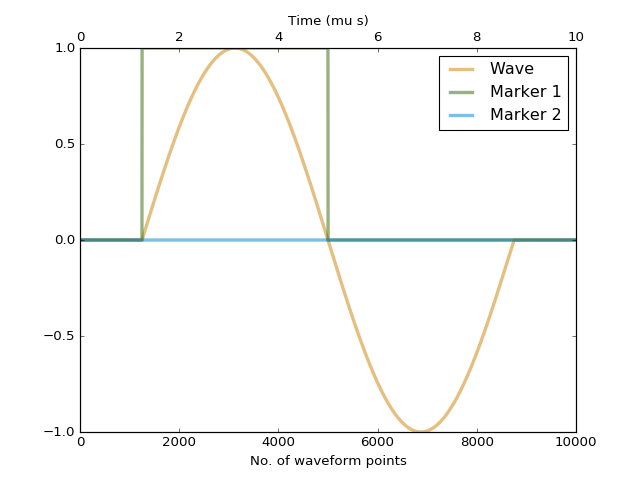

In [37]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(makesinewf(N, 1), lw=3, alpha=0.5, color=(0.8, 0.5, 0), label='Wave')
ax1.plot(m1, lw=3, alpha=0.5, color=(0.2, 0.4, 0), label='Marker 1')
ax1.plot(m2, lw=3, alpha=0.5, color=(0, 0.5, 0.8), label='Marker 2')
ax1.set_ylim([-1.1, 1.1])
ax1.set_xlabel('No. of waveform points')
plt.legend()
ax2 = ax1.twiny()
ax2.plot(np.arange(N)/1e3, wf, lw=0)
ax2.set_xlabel('Time (mu s)')

### Approach A 

In [50]:
awg1.visa_handle.write('MMEMory:CDIRectory "C:\\Users\\OEM\\Documents"')

(45, <StatusCode.success: 0>)

In [39]:
noOfseqs = 40

pckd_wfs = []
#pckd_wf = np.zeros(N, dtype='uint16')

chan1_list = []
for ii in range(noOfseqs):
    pckd_wf = awg1.pack_waveform(makesinewf(N, 1+ii), m1, m2)
    pckd_wfs.append(pckd_wf)
    chan1_list.append('segm{:03d}ch1'.format(ii))
wfname_l = np.array([chan1_list], dtype='str')
packed_wfs = {}

#packed_wfs.update
for name, wf_dummy in zip(wfname_l[0], pckd_wfs):
    packed_wfs.update({name: wf_dummy})

#
nrep_l = [1]*noOfseqs
wait_l = [0]*noOfseqs
goto_l = list(np.arange(2, noOfseqs+1))+[1]
logic_jump = [0]*noOfseqs
channel_cfg = {}
awg_file = awg1.generate_awg_file(packed_wfs, wfname_l, nrep_l,
                                  wait_l, goto_l, logic_jump, channel_cfg)


In [40]:
awgfilename = 'manySinesIncreasingFreq.awg'
t1 = time.time()
awg1.send_awg_file(awgfilename, awg_file)
loadfrom = '{}{}'.format(awg1.visa_handle.query('MMEMory:CDIRectory?').replace('"','').replace('\n', '\\'), awgfilename)
awg1.load_awg_file(loadfrom)
awg1.visa_handle.query('*IDN?')  # a dummy query to get the timing right
t2 = time.time()
print('Transferred and loaded {} {}-point waveforms in {:0.3f} seconds.'.format(noOfseqs, N, t2-t1))
#awg1.load_awg_file(loadfrom)

Transferred and loaded 40 10000-point waveforms in 6.195 seconds.


In [26]:
awg1.set_sqel_goto_target_index(3, 4)

In [80]:
# we need this to run
awg1.visa_handle.write('SOUR1:ROSC:SOUR INT')
awg1.visa_handle.write('OUTP1 ON')
awg1.run()

'Running'

In [45]:
filename = 'manySinesINcreasingFreq.awg'
loadfrom = '{}{}'.format(awg1.visa_handle.query('MMEMory:CDIRectory?').replace('"','').replace('\n', '\\'), filename)
awg1.visa_handle.write('MMEM:IMP {},{}'.format('mylist', loadfrom))
awg1.visa_handle.write('SOURce1:WAV {}'.format('mylist'))

(20, <StatusCode.success: 0>)

In [16]:
awg1.stop()

### Approach B

In [59]:
awg1.delete_all_waveforms_from_list()

In [60]:
noOfwfs = 20
t1 = time.time()
for ii in range(noOfwfs):
    wfmname = 'hiswaveform{:03d}'.format(ii)
    awg1.send_waveform_to_list(makesinewf(N, 1+ii), m1, m2, wfmname, silent=True)
    awg1.set_sqel_waveform(wfmname, 1, ii+1)
awg1.visa_handle.query('*IDN?')  # a dummy query to get the timing right
t2 = time.time()
print('Transferred {} {}-point waveforms in {:0.3f} seconds.'.format(noOfwfs, N, t2-t1))

/Users/william/.pyenv/versions/anaconda3-4.1.1/envs/qcodesmaster/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Transferred 20 10000-point waveforms in 27.037 seconds.


In [58]:
awg1.upload_awg_file('testfile.awg', awg_file)

upload time:  0.0010411739349365234
setting time:  0.298145055770874


In [57]:
awg1._rem_file_path = '\\\\AWG-3289382193\\WaveformLib'

In [47]:
awg1.visa_handle.query('*IDN?')

'TEKTRONIX,AWG5014C,B051039,SCPI:99.0 FW:4.6.0.7 \n'